In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import astropy
from astropy.modeling import models, fitting
import pylab as pl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.models import Voigt1D
import glob
from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import fwhm
from scipy.integrate import simps
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
def find_EW(window_cell1,window_cell2, lamda_cell, y_cell):
    
    #Inputs are the index of the window for cell and lamp (not always the same) after binning and converting to wavelength
    
    data_cell = y_cell[window_cell1:window_cell2]
    wav_cell = lamda_cell[window_cell1:window_cell2]
    spec = data_cell/max(data_cell)
    
    #Prints line profile for sanity check
    plt.figure()
    plt.plot(wav_cell,spec,'o-')
    plt.hlines(y=min(spec), xmin=min(wav_cell), xmax=max(wav_cell),
              color='red', linestyle='--');
    plt.grid();
    plt.title('Normalized Y-axis to find EW')
    plt.xlabel('Wavelength (AA)')
    plt.ylabel('Normalized Counts s-1 AA-1')
    
    #Calculate using specutils. Need to assume correct units even though they currently are not
    spec1 = Spectrum1D(spectral_axis=wav_cell*u.AA, flux=spec*u.Unit('erg cm-2 s-1 AA-1'))
    EW_cell = equivalent_width(spec1, continuum = min(spec)*u.Unit('erg cm-2 s-1 AA-1'), regions=SpectralRegion(min(wav_cell)*u.AA, max(wav_cell)*u.AA))
    
    #Calculate EW using numerical integration following formula. Usually very close to specutils
    a = (min(data_cell)-(data_cell))/min(data_cell)
    
    #Calculates intensity of line profile. Can use just this to calculate transmission and optical depth
    I0 = (simps(data_cell,wav_cell))
    
    EW_2 = simps(a,wav_cell)
    
    return EW_cell*-1, EW_2*-1,I0

def bin_data(lamda_lamp,y_lamp,new_spacing=0.35):    
    # Define the starting and ending points for the extended x-axis
    start_point = lamda_lamp.min()
    end_point = lamda_lamp.max()

    #new_spacing = 0.35
    # Calculate the number of bins based on the new spacing
    num_bins = int(np.ceil((end_point - start_point) / new_spacing))

    # Initialize an array to store the bin sums
    bin_sums = np.zeros(num_bins)
    x_bin=[]
    # Iterate over the extended x-axis and sum the corresponding y-values for each bin
    for i in range(num_bins):
        # Calculate the bin edges
        bin_start = start_point + i * new_spacing
        bin_end = bin_start + new_spacing

        # Select the points within the current bin
        points_in_bin = y_lamp[(lamda_lamp >= bin_start) & (lamda_lamp < bin_end)]

        # Sum the y-values in the current bin
        x_bin.append(bin_start)
        bin_sums[i] = np.sum(points_in_bin)
        
    bin_sums = np.clip(bin_sums, a_min=0.01, a_max=None)
    
    return x_bin, bin_sums

In [10]:
def wav_calibrate_and_ratio(lamp_inst,cell_inst,dark_inst):
    '''
    Designed to take list of files as inputs but can be used for just path to one cell, lamp and dark
    '''
    
    #date = datetime.now().strftime('%m_%d_%Y') #when plotting today's data
    #date = '04_23_2024' #to type in past date
    #id_lamp='lamp1000_10V_3T'
    #id_dark = 'dark_6A_3T'
    #id_filament_dark = 'darkf1000_10V_3T'
    #id_cell = 'cell1000_10V_3T'
    # Base filenam
    lamp_filename = lamp_inst
    #lamp_filename = f'1000V/{date}_{id_lamp}_processed.csv'
    filament_dark_filename = dark_inst
    #filament_dark_filename = f'1000V/{date}_{id_filament_dark}_processed.csv'
    #cell_filename = f'1000V/{date}_{id_cell}_processed.csv'
    cell_filename = cell_inst
    # Specific filenames

    df_lamp = pd.read_csv(lamp_filename)
    #df_dark = pd.read_csv(dark_filename)
    df_darkf = pd.read_csv(filament_dark_filename)
    df_cell = pd.read_csv(cell_filename)
    #savefile for wavelength scale data
    columns = ['wavelength', 'Source (counts)', 'wavelength', 'Cell (counts)', 'wavelength', 'Filament (counts)']
    #savefile = f'{date}_scaled_spectra.csv' 

    xr_lamp=df_lamp['xr']
    y_lamp = df_lamp['y']
    #xr_dark = df_dark['xr']
    #y_dark = df_dark['y']
    xr_darkf = df_darkf['xr']
    y_darkf = df_darkf['y']
    xr_cell = df_cell['xr']
    y_cell = df_cell['y']

    integration_time = 10 #in seconds
    bandpass = 1650 - 900 #Angstroms

    #Cut down the spectra in y 
    # After calculating y, y_raw, etc.
    y_cut_min, y_cut_max = 660, 1300
    filtered_lamp = df_lamp[(df_lamp['y'] >= y_cut_min) & (df_lamp['y'] <= y_cut_max)]
    #filtered_dark = df_dark[(df_dark['y'] >= y_cut_min) & (df_dark['y'] <= y_cut_max)]
    filtered_darkf = df_darkf[(df_darkf['y'] >= y_cut_min) & (df_darkf['y'] <= y_cut_max)]
    filtered_cell = df_cell[(df_cell['y'] >= y_cut_min) & (df_cell['y'] <= y_cut_max)]
    # Now, if you need to apply similar filtering to df_dark based on xr_lamp, ensure it's done based on a common key or parameter.

    # Grouping and summing lamp counts after filtering
    lamp_counts = filtered_lamp.groupby('xr')['y'].sum().reset_index()
    #dark_counts = filtered_dark.groupby('xr')['y'].sum().reset_index()
    darkf_counts = filtered_darkf.groupby('xr')['y'].sum().reset_index()
    cell_counts = filtered_cell.groupby('xr')['y'].sum().reset_index()

    lamp_flux = lamp_counts/(integration_time * bandpass)
    cell_flux = cell_counts/(integration_time * bandpass)

    # If you have dark counts prepared similarly, calculate the average
    # Assuming dark_counts DataFrame is prepared correctly
    avg_dark = df_darkf['y'].mean()


    # Prepare final xr_lamp and y_lamp for further calculations or plotting
    xr_lamp = lamp_counts['xr'].values 
    y_lamp = lamp_counts['y'].values - avg_dark
    #xr_dark = dark_counts['xr'].values
    #y_dark = dark_counts['y'].values
    xr_darkf = darkf_counts['xr'].values
    y_darkf = darkf_counts['y'].values
    xr_cell = cell_counts['xr'].values 
    y_cell = cell_counts['y'].values - avg_dark

    
    #This part calibrates the wavelength based on the input guesses for pixel space
    #The weights are used so that if ly_alpha shifts pixels between data, it will seek the 
    #closest line maximum. If an error pops up saying there is no value for px2 or px3, then 
    #there are usually too few pixels in the data set too use
    
    guessed_Angstroms = [1215.67, 1304, 1334]
    
    px1 = np.where(np.isclose(xr_lamp, 812, atol=1))[0][0]
    px2 = np.where(np.isclose(xr_lamp, 1054, atol=3))[0][0]
    px3 = np.where(np.isclose(xr_lamp, 1150, atol=5))[0][0]
    guessed_pixels_index = [px1,px2,px3]
    print(guessed_pixels_index)
    npixels = 30
    improved_xval_guesses = [np.average(xr_lamp[g-npixels:g+npixels],
                                        weights=y_lamp[g-npixels:g+npixels])
                             for g in guessed_pixels_index]
    print(improved_xval_guesses)
    print(y_lamp[guessed_pixels_index])
    linfitter = LinearLSQFitter()
    wlmodel = Linear1D()
    linfit_wlmodel = linfitter(model=wlmodel, x=xr_lamp[guessed_pixels_index], y=guessed_Angstroms)
    lamda_lamp = linfit_wlmodel(xr_lamp)
    lamda_cell = linfit_wlmodel(xr_cell)
    lamda_darkf = linfit_wlmodel(xr_darkf)
    
    #The slope should be close to 0.36 and intercept should be close to 930
    print(linfit_wlmodel)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    ax1.plot(xr_lamp, y_lamp,ls='-', markersize=3.5, label='Source')
    ax1.plot(xr_cell, y_cell,ls='-', markersize=3.5, label='Cell')
    #plt.plot(xr_dark, y_dark,ls='-', markersize=.5, label='Data')
    #plt.plot(xr_darkf, y_darkf,ls='-', markersize=.5, label='Data')
    for x in xr_lamp[guessed_pixels_index]:
        ax1.axvline(x=x,label='Identified Peaks',color='red',linestyle='--',linewidth=0.5)

    ax1.set_xlabel('Pixels')
    ax1.set_ylabel('Counts * s-1 *AA-1')
    ax1.set_title(f'Plots for {lamp_inst[17:30]} and {cell_inst[17:30]}')
    ax1.legend()
    #ax1.set_xlim(3000, 3420)

    #plt.show()

    #plt.figure(figsize=(10, 6))
    ax2.plot(lamda_lamp, y_lamp,'o-', markersize=.5, label='Source')
    ax2.plot(lamda_cell, y_cell,'o-', markersize=.5, label='Cell')

    ax2.plot(guessed_Angstroms, [2600]*3,'x', label='Identified Peaks')
    ax2.set_xlabel('Angstroms')
    ax2.set_ylabel('Counts * s-1 *AA-1')
    #ax2.set_title('Attenuation at 9  amps')
    ax2.legend()
    #plt.show()

    #plt.figure(figsize=(10, 6))
    ax3.plot(lamda_lamp, y_lamp,'o-', label='Source')
    ax3.plot(lamda_cell, y_cell, 'o-', label='Cell')
    #plt.plot(lamda_darkf, y_darkf, ls='-', ms=.5, label='Filament') #Only if lines are seen from darkf
    for x in guessed_Angstroms:
        ax3.axvline(x=x,label='Identified Peaks',color='red',linestyle='--',linewidth=0.5)
        
    ax3.set_xlabel('Angstroms')
    ax3.set_ylabel('Counts * s-1 *AA-1')
    #ax3.set_title('Lyman Alpha Comparison')
    ax3.set_xlim(1211, 1220)
    ax3.legend()
    #plt.show()
    
    #Save the wavelength calibration to a png in data_plots directory. Can save np.txt file of array too
    fig.savefig(f'data_plots/Wavelength_cal_{lamp_inst[6:29]}.png')
    
    #Bin to correct dispersion to make usable data
    x_bin,bin_sums = bin_data(lamda_lamp,y_lamp)
    x_cell, cell_sum = bin_data(lamda_cell,y_cell)
    
    #Define window around 1215.6 that will almost always encompass broad line profile
    lamp_window1 = np.where(np.isclose(x_bin, 1213.5, atol=0.2))[0][0]
    lamp_window2 = np.where(np.isclose(x_bin, 1218.5, atol=0.2))[0][0]
    cell_window1 =np.where(np.isclose(x_cell, 1213.5, atol=0.3))[0][0]
    cell_window2 = np.where(np.isclose(x_cell, 1218.5, atol=0.3))[0][0]
    
    #cell_window1
    lamp_line_val = bin_sums[lamp_window1:lamp_window2]
    lamp_line = np.array(x_bin[lamp_window1:lamp_window2])
    
    #This is to make a voigt profile of lamp data
    '''
    lmfitter = LevMarLSQFitter()
    guess = Voigt1D(x_0=1215.75,amplitude_L=lamp_line_val.max(),fwhm_L=1 , fwhm_G=0.3)
    fitted_trace_profile = lmfitter(model=guess, x=lamp_line, y=lamp_line_val)
    model_trace_profile = fitted_trace_profile(np.linspace(1213,1218))
    print(fitted_trace_profile)
    plt.figure(figsize=(8, 6))
    plt.plot(lamp_line,lamp_line_val,'o',label='Lamp Source')
    plt.plot(np.linspace(1213,1218),model_trace_profile,linewidth=2.5,label='Voight Profile Fit',color='red',linestyle='--')
    plt.plot(np.array(x_cell[cell_window1:cell_window2]),cell_sum[cell_window1:cell_window2],'ko-',label='Cell Attenuated Data')
    plt.grid()
    plt.xlabel('Angstroms')
    plt.ylabel('Counts * s-1 *AA-1')
    plt.title('Ly$\\alpha$ Line Profiles')
    plt.legend()
    plt.savefig('Line_profiles.png')
    '''   
    
    
    EW_lamp,EW2,I0 = find_EW(lamp_window1,lamp_window2,x_bin,bin_sums)
    plt.savefig(f'data_plots/EW_plot_{lamp_inst[6:30]}.png')
    print(f'Equivalent Width SpecUtils:{EW_lamp:.2f}, EW Manual:{EW2:.2f}, Intensity:{I0:.2f}')
    
    EW_cell,EW2,I = find_EW(cell_window1,cell_window2,x_cell,cell_sum)
    plt.savefig(f'data_plots/EW_plot_{cell_inst[6:30]}.png')
    print(f'Equivalent Width SpecUtils:{EW_cell:.2f}, EW Manual:{EW2:.2f}, Intensity:{I:.2f}')
    
    transmission = I/I0
    print(f'Transmission is {I/I0:.2f} and Optical Depth is {-1*np.log(I/I0) :.2f} for {cell_inst[6:30]}.')
    
    
    return transmission, EW_lamp, EW_cell, (-1*np.log(I/I0))


'''
remember to test both with and without darks to see any effects. Remember to take different slice of detector and see if helps.
remember area on detector to eventually convert to correct units
'''

'\nremember to test both with and without darks to see any effects. Remember to take different slice of detector and see if helps.\nremember area on detector to eventually convert to correct units\n'

In [11]:
#Make list of data using glob. Dump data into a directory and then make path to directory
#Differentiate between lamp and cell using the *
date = '04_24_2024'
lamp_list = glob.glob(f'2000V/{date}_lamp*')
cell_list = glob.glob(f'2000V/{date}_cell*')
dark_list = glob.glob(f'2000V/{date}_dark*')
np.array(lamp_list)

#Make sure to check lists so that each cell data has a lamp data

array(['2000V\\04_24_2024_lamp2_2000_10V_3T_processed.csv',
       '2000V\\04_24_2024_lamp2_2000_12V_3T_processed.csv',
       '2000V\\04_24_2024_lamp2_2000_6V_3T_processed.csv',
       '2000V\\04_24_2024_lamp2_2000_7V_3T_processed.csv',
       '2000V\\04_24_2024_lamp2_2000_8V_3T_processed.csv',
       '2000V\\04_24_2024_lamp2_2000_9V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_10V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_12V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_14V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_6V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_7V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_8V_3T_processed.csv',
       '2000V\\04_24_2024_lamp_2000_9V_3T_processed.csv'], dtype='<U48')

[58, 115, 134]
[809.9294254198671, 1029.929467813752, 1090.2001267762146]
[1199.35987013  237.06987013  -71.64012987]
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope           intercept    
    ----------------- -----------------
    0.356184441487874 927.1849437071668
Equivalent Width SpecUtils:4167138.68 Angstrom, EW Manual:4216626.58, Intensity:42166.31
Equivalent Width SpecUtils:2402798.49 Angstrom, EW Manual:2183830.92, Intensity:21838.36
Transmission is 0.52 and Optical Depth is 0.66 for 04_24_2024_cell2_2000_10.
[135, 304, 369]
[810.7246293516436, 1050.1425734197903, 1149.0956446451355]
[14826.87987013   229.07987013  1545.87987013]
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope           intercept    
    ------------------ ----------------
    0.3567051666873518 926.959737062596
Equivalent Width SpecUtils:10992643.35 Angstrom, EW Manual:11027100.28, Intensity:110271.05
Equivalent Width S

C:\Users\jackf\AppData\Local\Temp\ipykernel_33396\1683381379.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Equivalent Width SpecUtils:211.37 Angstrom, EW Manual:209.33, Intensity:123976.65
Equivalent Width SpecUtils:1623452.79 Angstrom, EW Manual:1630553.47, Intensity:16305.58
Transmission is 0.13 and Optical Depth is 2.03 for 04_24_2024_cell_2000_12V.
[92, 209, 250]
[810.6375869399127, 1028.7151037020649, 1142.9591020267212]
[8360.61987013 1025.83987013 2593.71987013]
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.3556836566675881 927.5984768960197
Equivalent Width SpecUtils:981.40 Angstrom, EW Manual:975.71, Intensity:77842.12
Equivalent Width SpecUtils:4140117.96 Angstrom, EW Manual:4103496.86, Intensity:41035.01
Transmission is 0.53 and Optical Depth is 0.64 for 04_24_2024_cell_2000_14V.
[148, 319, 383]
[810.5414200408766, 1036.1594966041557, 1148.964748043035]
[1.44709299e+04 1.25198701e+01 1.56639870e+02]
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1

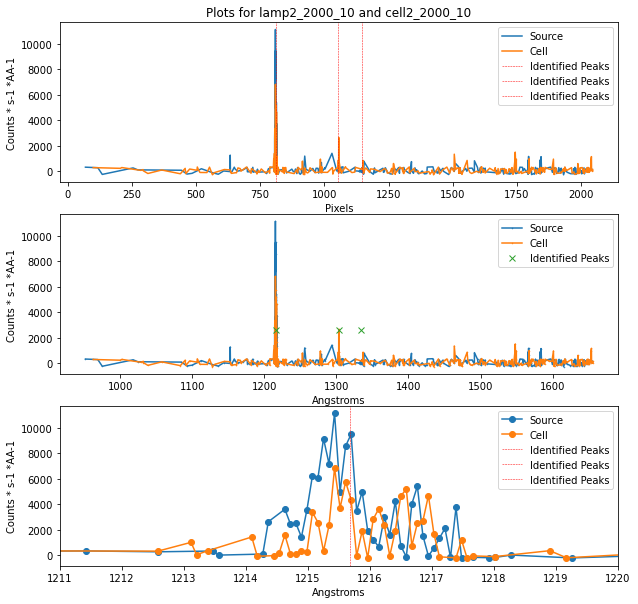

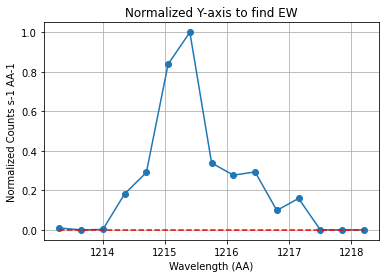

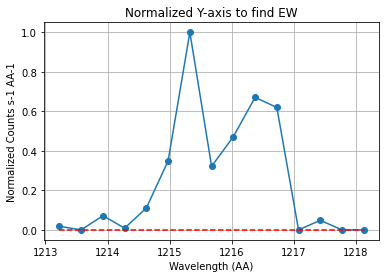

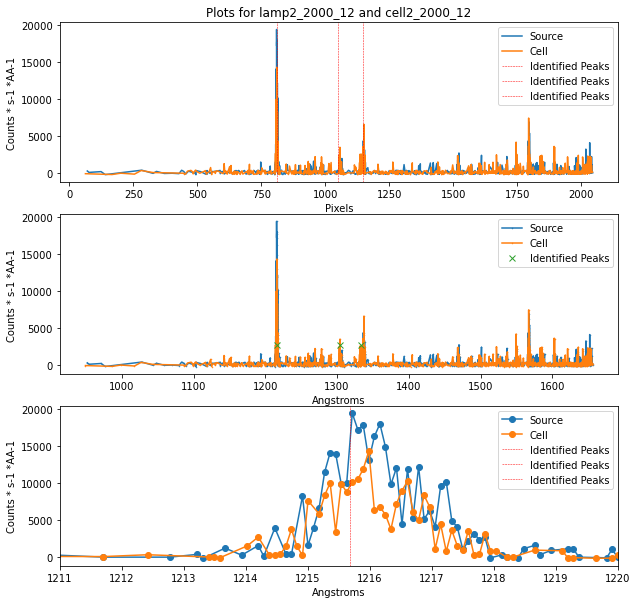

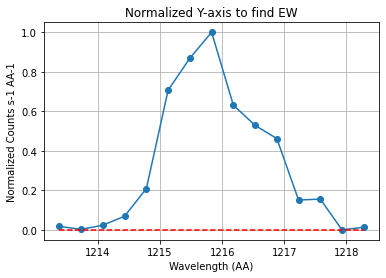

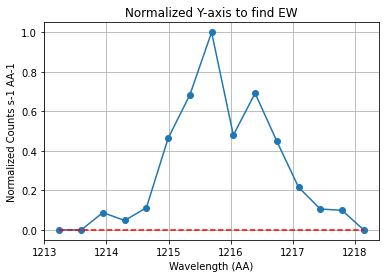

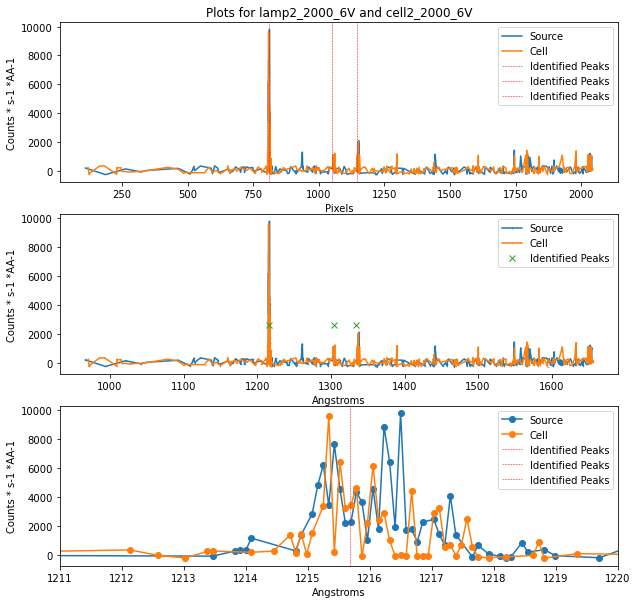

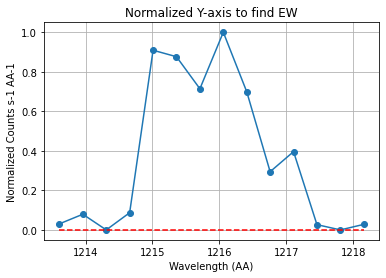

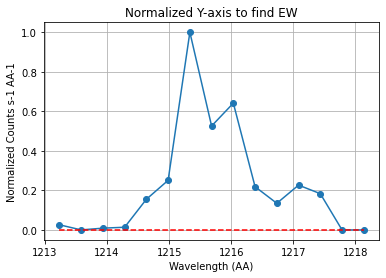

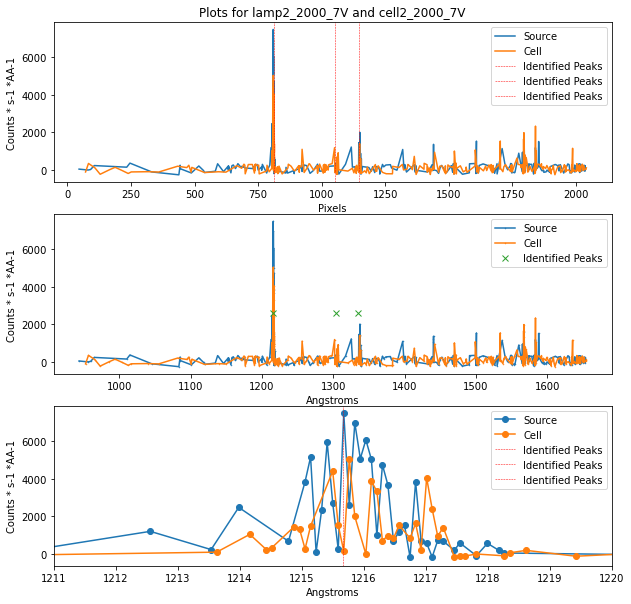

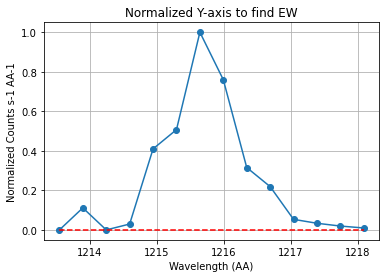

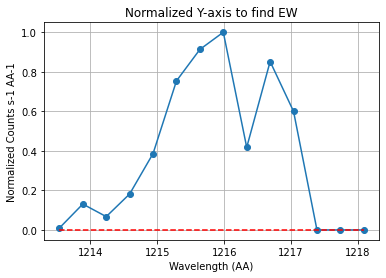

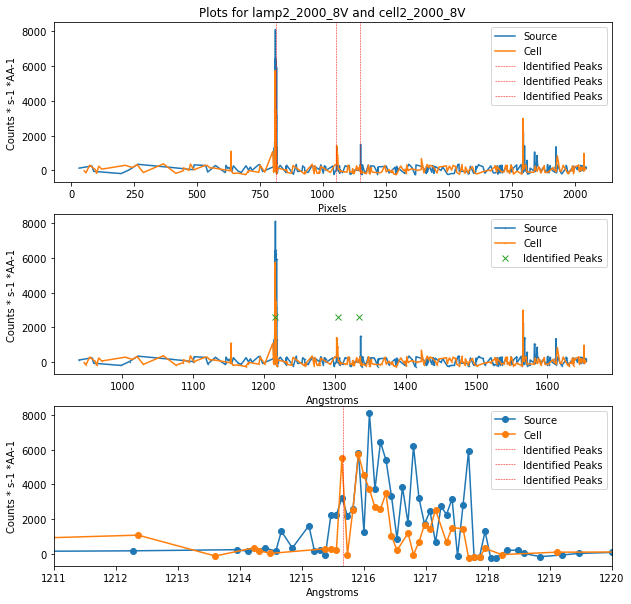

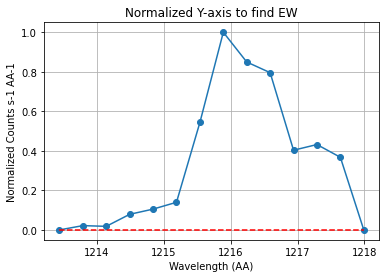

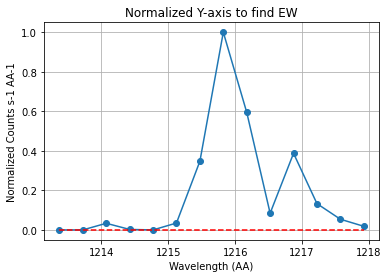

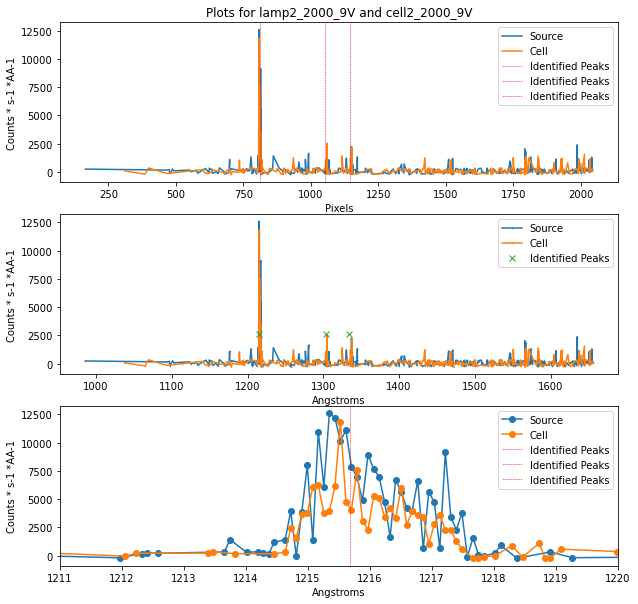

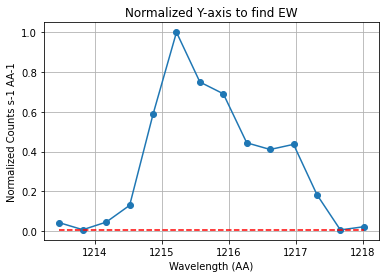

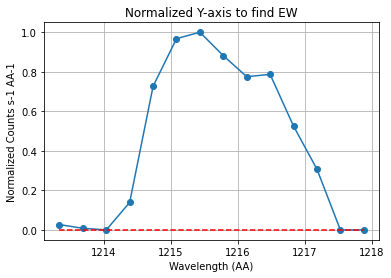

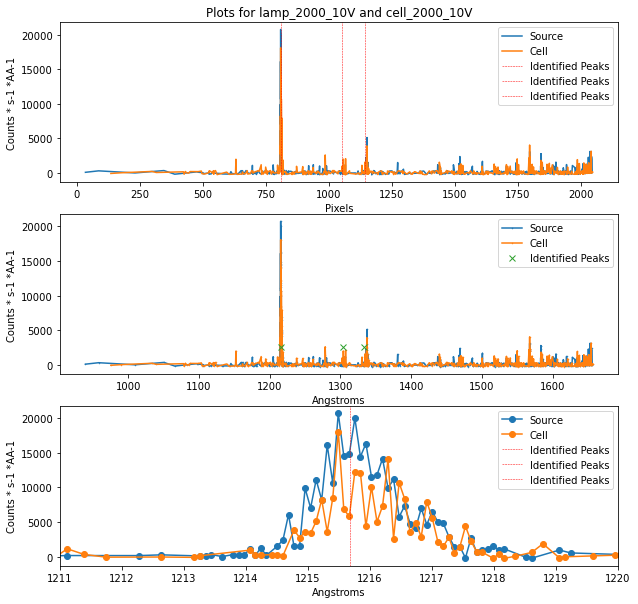

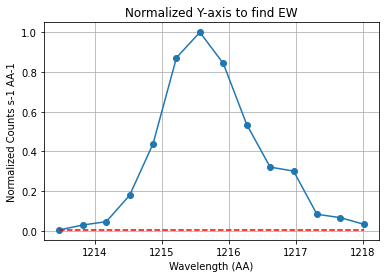

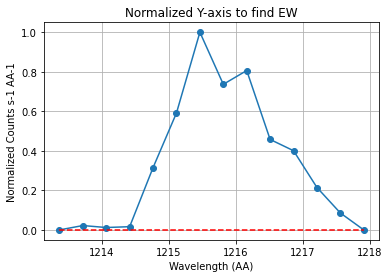

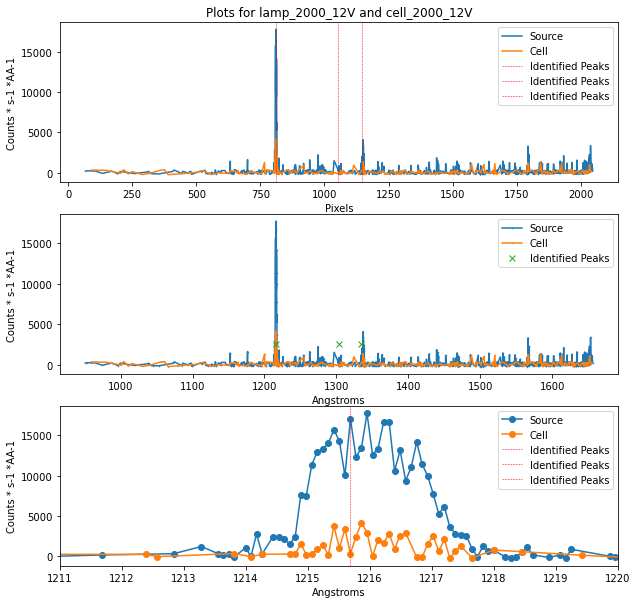

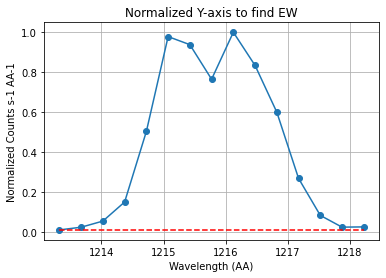

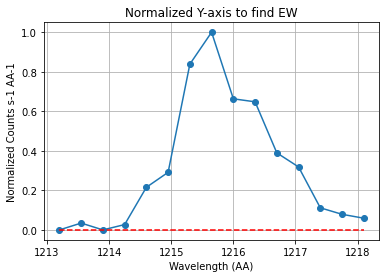

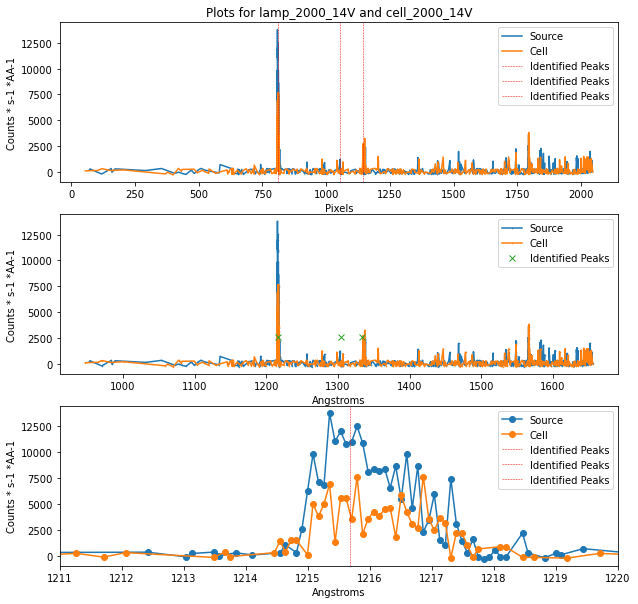

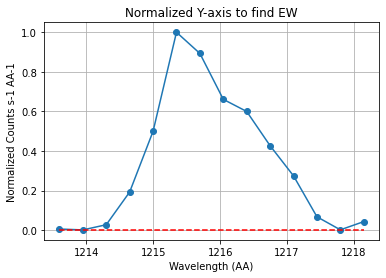

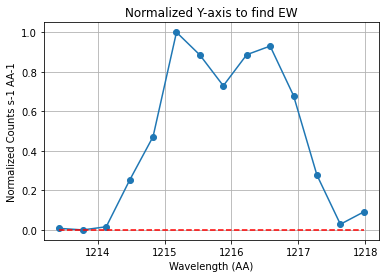

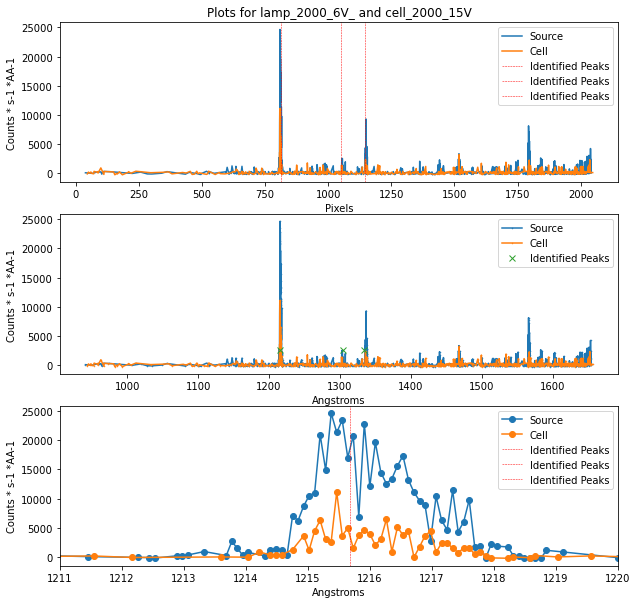

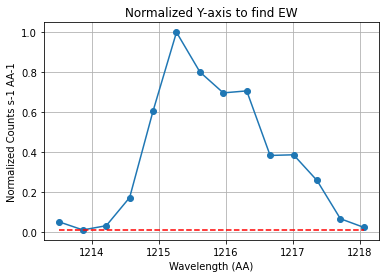

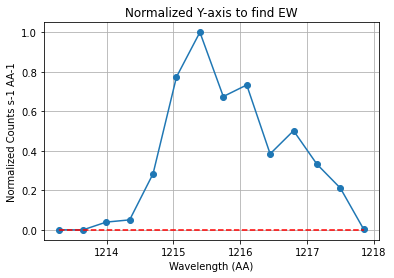

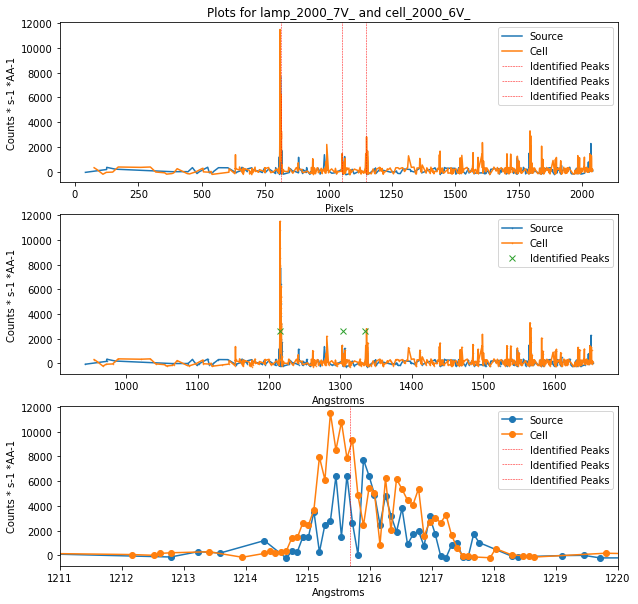

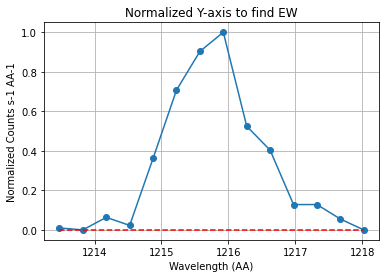

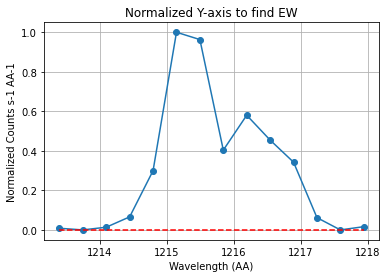

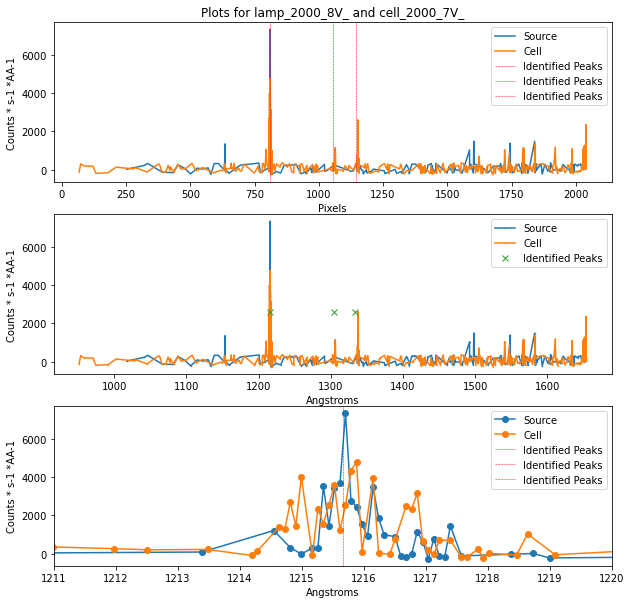

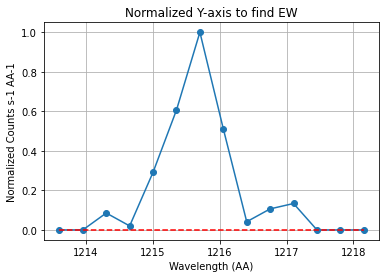

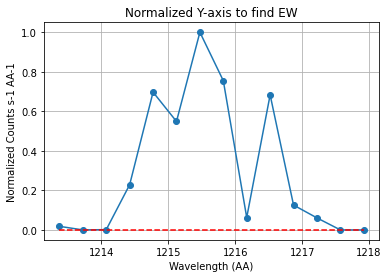

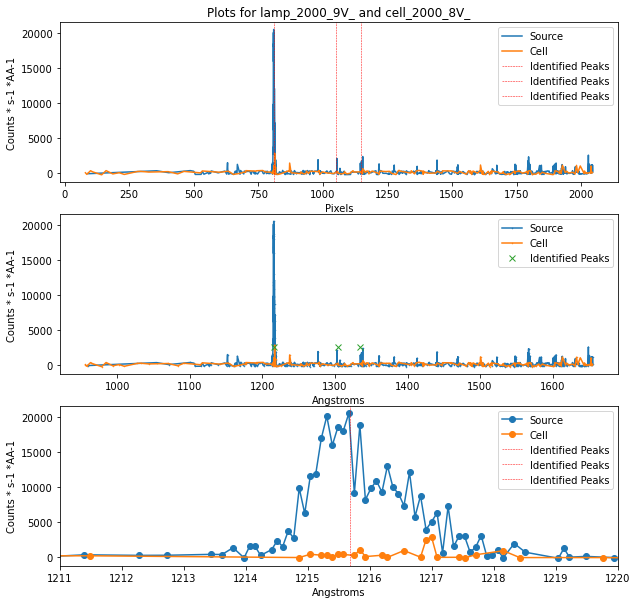

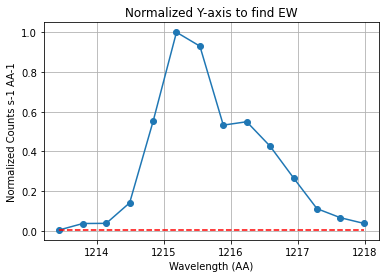

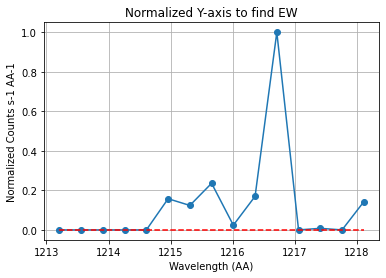

In [12]:
trans=[]
EW_lamps=[]
EW_cell=[]
taus=[]

#Will return array of all transmission, EW, and optical depth of data runs
#Will automatically plot all data processed and saved to folders
for i in range(len(lamp_list)):
    
    t,EW_l, EW_c, tau  = wav_calibrate_and_ratio(lamp_list[i],cell_list[i],dark_list[0])
        
    trans.append(t)
    EW_lamps.append(EW_l)
    EW_cell.append(EW_c)
    taus.append(tau)